<a href="https://colab.research.google.com/github/Shailajgautam/FDV-AI-Intern-Task/blob/main/Intern_Week_4_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mounting Google Drive**

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


# **Importing required dependencies**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# **Imporing dataset and performing analysis**

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Nepali_Dataset_New.csv")

In [ ]:
# Display basic information about the dataset
print(data.head())
print(data.info())

                                                News       Category
0  \n﻿काठमाण्डौ, ६ असार । नेपाल ललितकला प्रज्ञा प...       politics
1  नेपालको आशा जीवितैकप्तान पारस खड्काले ब्याट र ...          sport
2  \n﻿राजविराज, २६ फागुन । नेकपा एमालेलाई औद्योगि...       politics
3  सामाजिक कार्यका लागि सुन्दरी"\nसौन्दर्य प्रतिय...  entertainment
4  खराब प्रदर्शनपछि प्रशिक्षण पिच"महिला राष्ट्रिय...          sport
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4540 entries, 0 to 4539
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   News      4540 non-null   object
 1   Category  4540 non-null   object
dtypes: object(2)
memory usage: 71.1+ KB
None


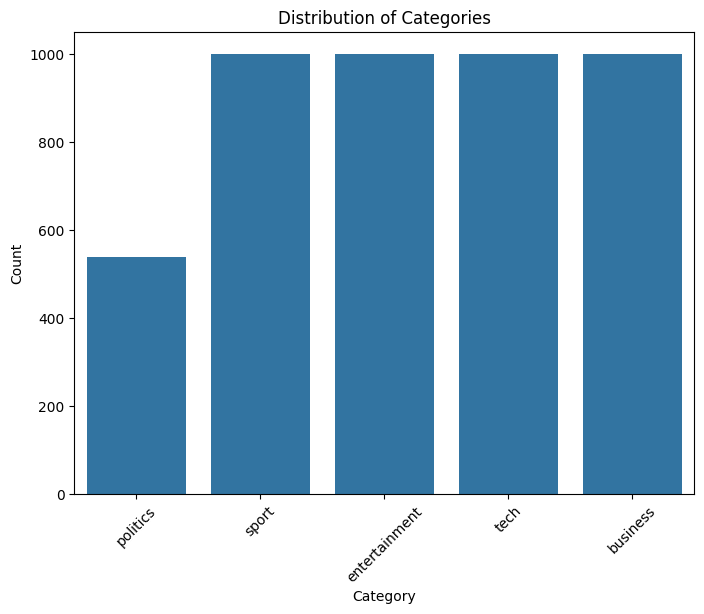

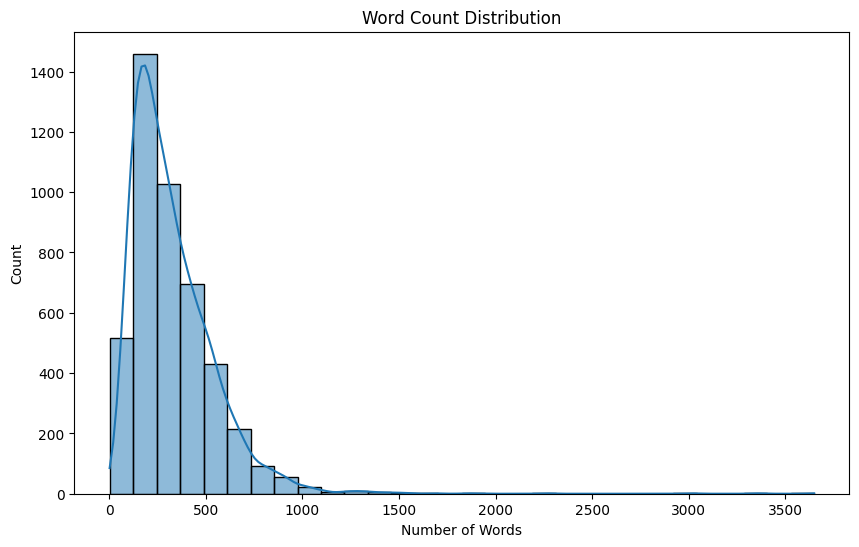

In [ ]:
# Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of categories
plt.figure(figsize=(8, 6))
sns.countplot(x='Category', data=data)
plt.title('Distribution of Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Word count distribution
data['Word_Count'] = data['News'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(data['Word_Count'], bins=30, kde=True)
plt.title('Word Count Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.show()



# **Preprocessing Data**

In [ ]:
!pip install nepali-stemmer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.0/149.0 kB 4.2 MB/s eta 0:00:00


In [ ]:
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nepali_stemmer.stemmer import NepStemmer
from sklearn.preprocessing import LabelEncoder


# Load Nepali stop words from a text file
with open('/content/nepali_stopwords.txt', 'r', encoding='utf-8') as file:
    nepali_words = file.read().splitlines()

# Preprocess the news text: remove stop words
# data['Cleaned_News'] = data['News'].apply(lambda x: ' '.join([word for word in x.split() if word not in nepali_words]))

nepstem = NepStemmer()

punctuations = ['।', ',', ';', '?', '!', '—', '-', '.']

url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'


# Preprocess the news text: remove stop words
data['Cleaned_News'] = data['News'].apply(lambda x: ' '.join([nepstem.stem(word) for word in re.sub(url_pattern, '', x).split() if word not in nepali_words and word not in punctuations]))


# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Cleaned_News'])
word_index = tokenizer.word_index
print("Number of unique tokens:", len(word_index))

# Padding sequences
max_length = 2000
sequences = tokenizer.texts_to_sequences(data['Cleaned_News'])
padded_sequences = pad_sequences(sequences, maxlen=max_length)

# Label encode the 'Category' column
label_encoder = LabelEncoder()
category_encoded = label_encoder.fit_transform(data['Category'])

# Assign the encoded values back to the DataFrame
data['label_encoded_category'] = category_encoded


Number of unique tokens: 64637


# **Building Models**

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Define function to build RNN model
def build_rnn_model(vocab_size, embedding_dim, max_length):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        SimpleRNN(64),
        Dense(64, activation='relu'),
        Dense(5, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define function to build LSTM model
def build_lstm_model(vocab_size, embedding_dim, max_length):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        LSTM(64),
        Dense(64, activation='relu'),
        Dense(5, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define function to build GRU model
def build_gru_model(vocab_size, embedding_dim, max_length):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        GRU(64),
        Dense(64, activation='relu'),
        Dense(5, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, data['label_encoded_category'], test_size=0.2, random_state=42)

# Define model parameters
embedding_dim = 758
vocab_size = len(word_index)
epochs = 50
batch_size = 128

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Build RNN model with early stopping
rnn_model = build_rnn_model(vocab_size, embedding_dim, max_length)
rnn_history = rnn_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping])

# Build LSTM model with early stopping
lstm_model = build_lstm_model(vocab_size, embedding_dim, max_length)
lstm_history = lstm_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping])

# Build GRU model with early stopping
gru_model = build_gru_model(vocab_size, embedding_dim, max_length)
gru_history = gru_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping])

# Evaluate models
rnn_loss, rnn_accuracy = rnn_model.evaluate(X_test, y_test)
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test, y_test)
gru_loss, gru_accuracy = gru_model.evaluate(X_test, y_test)

# Print accuracies
print("RNN Accuracy:", rnn_accuracy)
print("LSTM Accuracy:", lstm_accuracy)
print("GRU Accuracy:", gru_accuracy)


Epoch 1/50
23/23 [==============================] - 58s 2s/step - loss: 1.4097 - accuracy: 0.3914 - val_loss: 1.1717 - val_accuracy: 0.4759
Epoch 2/50
23/23 [==============================] - 55s 2s/step - loss: 0.7609 - accuracy: 0.7986 - val_loss: 0.8593 - val_accuracy: 0.6905
Epoch 3/50
23/23 [==============================] - 56s 2s/step - loss: 0.2077 - accuracy: 0.9752 - val_loss: 0.6339 - val_accuracy: 0.7442
Epoch 4/50
23/23 [==============================] - 54s 2s/step - loss: 0.0342 - accuracy: 0.9983 - val_loss: 0.6205 - val_accuracy: 0.7524
Epoch 5/50
23/23 [==============================] - 54s 2s/step - loss: 0.0108 - accuracy: 0.9993 - val_loss: 0.6817 - val_accuracy: 0.7442
Epoch 6/50
23/23 [==============================] - 54s 2s/step - loss: 0.0059 - accuracy: 0.9997 - val_loss: 0.6696 - val_accuracy: 0.7538
Epoch 7/50
23/23 [==============================] - 55s 2s/step - loss: 0.0043 - accuracy: 0.9997 - val_loss: 0.7266 - val_accuracy: 0.7455
Epoch 8/50
23/23 [==

# **Saving Models**

In [ ]:
# Save RNN model
rnn_model.save('/content/rnn_model.h5')

# Save LSTM model
lstm_model.save('/content/lstm_model.h5')

# Save GRU model
gru_model.save('/content/gru_model.h5')


# **Model Evaluation**

In [ ]:
from keras.models import load_model

# Load pre-trained model
rnn_model = load_model('/content/rnn_model.h5')

# Load pre-trained model
lstm_model = load_model('/content/lstm_model.h5')

# Load pre-trained model
gru_model = load_model('/content/gru_model.h5')

In [ ]:

from sklearn.metrics import classification_report

# Evaluate Simple RNN model
print("Simple RNN:")
rnn_loss, rnn_accuracy = rnn_model.evaluate(X_test, y_test)
print("Test Accuracy:", rnn_accuracy)
rnn_probabilities = rnn_model.predict(X_test)
rnn_predictions = np.argmax(rnn_probabilities, axis=1)
print(classification_report(y_test, rnn_predictions))

# Evaluate LSTM model
print("LSTM:")
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test, y_test)
print("Test Accuracy:", lstm_accuracy)
lstm_probabilities = lstm_model.predict(X_test)
lstm_predictions = np.argmax(lstm_probabilities, axis=1)
print(classification_report(y_test, lstm_predictions))

# Evaluate GRU model
print("GRU:")
gru_loss, gru_accuracy = gru_model.evaluate(X_test, y_test)
print("Test Accuracy:", gru_accuracy)
gru_probabilities = gru_model.predict(X_test)
gru_predictions = np.argmax(gru_probabilities, axis=1)
print(classification_report(y_test, gru_predictions))


Simple RNN:
29/29 [==============================] - 5s 151ms/step - loss: 0.6073 - accuracy: 0.7588
Test Accuracy: 0.7588105797767639
29/29 [==============================] - 5s 155ms/step
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       212
           1       0.63      0.60      0.62       194
           2       0.98      0.56      0.71       117
           3       0.82      0.98      0.89       186
           4       0.66      0.72      0.69       199

    accuracy                           0.76       908
   macro avg       0.79      0.74      0.75       908
weighted avg       0.77      0.76      0.75       908

LSTM:
29/29 [==============================] - 2s 38ms/step - loss: 0.2714 - accuracy: 0.9317
Test Accuracy: 0.9317180514335632
29/29 [==============================] - 2s 52ms/step
              precision    recall  f1-score   support

           0       0.96      0.84      0.89       212
           1       0.93      0

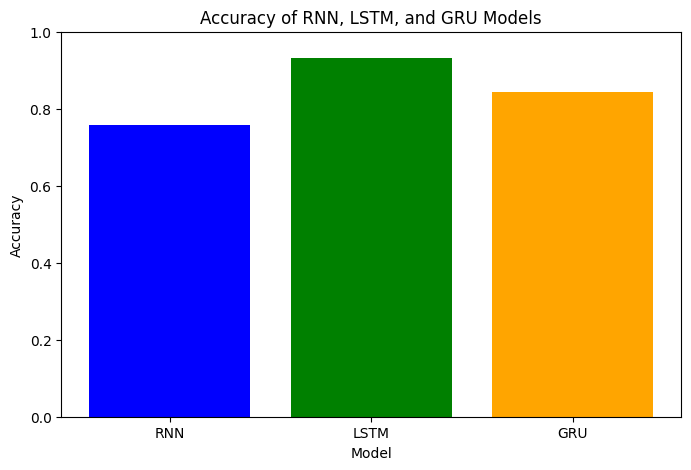

In [ ]:
import matplotlib.pyplot as plt

# Accuracy scores
models = ['RNN', 'LSTM', 'GRU']
accuracies = [rnn_accuracy, lstm_accuracy, gru_accuracy]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['blue', 'green', 'orange'])
plt.title('Accuracy of RNN, LSTM, and GRU Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()


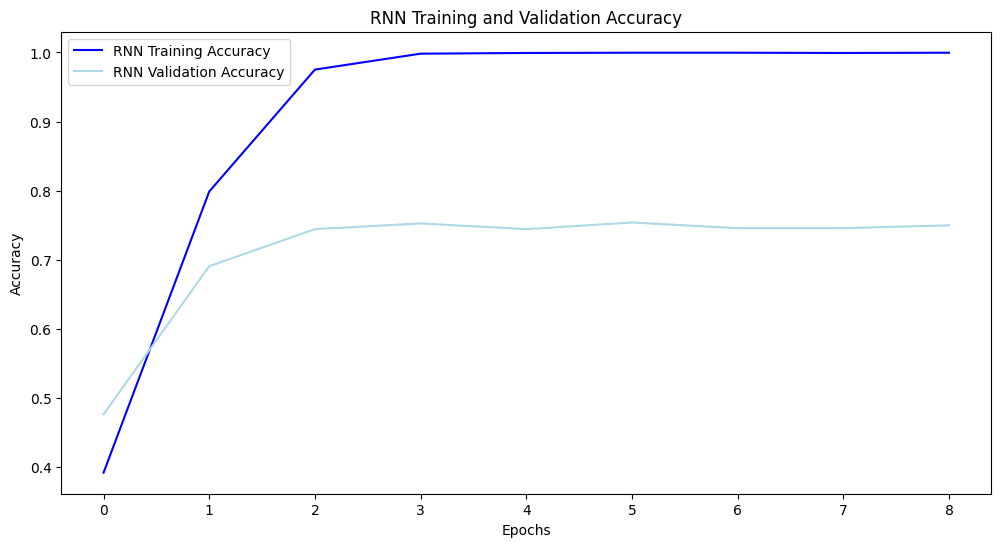

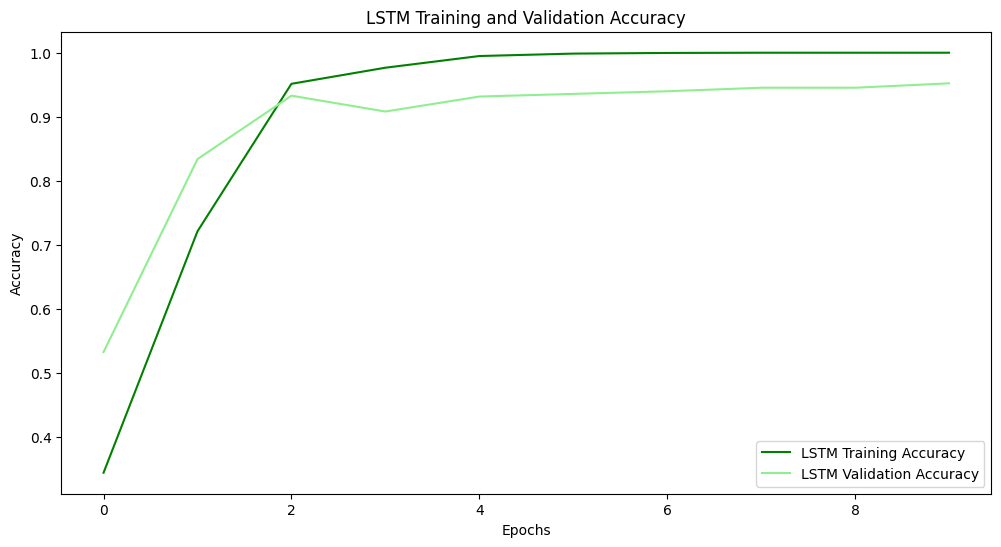

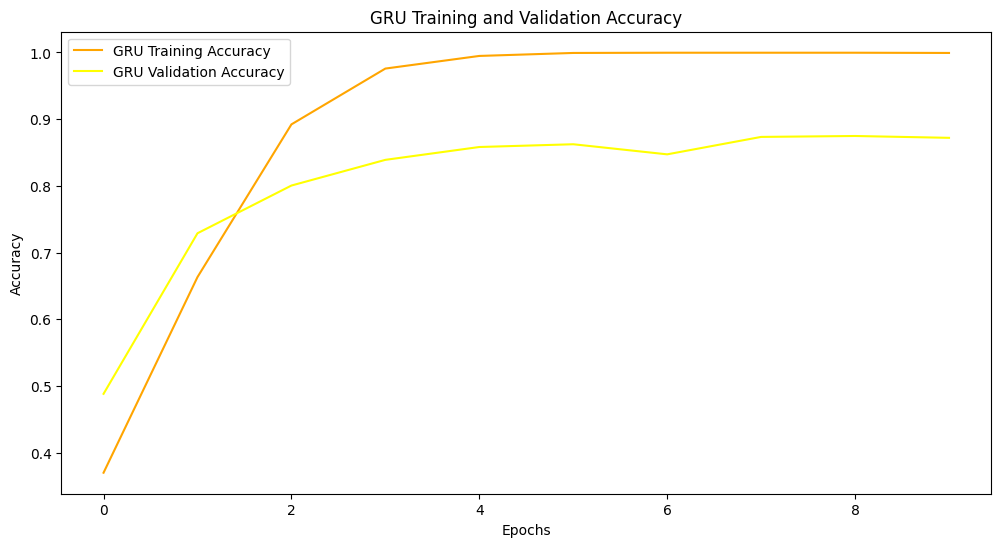

In [ ]:
import matplotlib.pyplot as plt

# Plot RNN learning curves
plt.figure(figsize=(12, 6))
plt.plot(rnn_history.history['accuracy'], label='RNN Training Accuracy', color='blue')
plt.plot(rnn_history.history['val_accuracy'], label='RNN Validation Accuracy', color='lightblue')
plt.title('RNN Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot LSTM learning curves
plt.figure(figsize=(12, 6))
plt.plot(lstm_history.history['accuracy'], label='LSTM Training Accuracy', color='green')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM Validation Accuracy', color='lightgreen')
plt.title('LSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot GRU learning curves
plt.figure(figsize=(12, 6))
plt.plot(gru_history.history['accuracy'], label='GRU Training Accuracy', color='orange')
plt.plot(gru_history.history['val_accuracy'], label='GRU Validation Accuracy', color='yellow')
plt.title('GRU Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# **Building Fastapi**

In [ ]:
!pip install fastapi
!pip install uvicorn
!pip install pyngrok


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.4/341.4 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from fastapi import FastAPI
from typing import List
from keras.models import load_model

In [ ]:
from pyngrok import ngrok

# Set your Ngrok authentication token
ngrok.set_auth_token("2fib4aJeAuxNLRiQX56IOJGCfiu_6ZNubAPMJdH1gpWpqqxdn")


In [ ]:
app = FastAPI()


In [ ]:
def clean_text(text):
    # Remove any non-Devanagari characters and specified punctuation
    cleaned_text = re.sub(r'[^\s।,;?!—\-.ऀ-ॿ]', '', text)
    return cleaned_text

def tokenize_text(text):
    # Split the text into tokens (words)
    tokens = text.split()
    return tokens

In [ ]:

@app.post("/predict/")
def predict(text: str):
    cleaned_text = clean_text(text)
    tokens = tokenize_text(cleaned_text)
    sequences = tokenizer.texts_to_sequences([tokens])
    padded_sequences = pad_sequences(sequences, maxlen=max_length)

    # Predict with the models
    rnn_prediction = rnn_model.predict(padded_sequences)
    rnn_predicted_class_index = np.argmax(rnn_prediction)
    rnn_predicted_class = label_encoder.inverse_transform([rnn_predicted_class_index])[0]

    lstm_prediction = lstm_model.predict(padded_sequences)
    lstm_predicted_class_index = np.argmax(lstm_prediction)
    lstm_predicted_class = label_encoder.inverse_transform([lstm_predicted_class_index])[0]

    gru_prediction = gru_model.predict(padded_sequences)
    gru_predicted_class_index = np.argmax(gru_prediction)
    gru_predicted_class = label_encoder.inverse_transform([gru_predicted_class_index])[0]

    return {
        "rnn_predicted_class": rnn_predicted_class,
        "lstm_predicted_class": lstm_predicted_class,
        "gru_predicted_class": gru_predicted_class
    }


In [ ]:
# Run FastAPI app using Uvicorn with Ngrok
import nest_asyncio
import uvicorn

# Run FastAPI app
def run_app():
    nest_asyncio.apply()
    uvicorn.run(app, host="0.0.0.0", port=8000)

# Start Ngrok tunnel
def start_ngrok():
    ngrok_tunnel = ngrok.connect(8000)
    print("Public URL:", ngrok_tunnel.public_url)
    return ngrok_tunnel

if __name__ == "__main__":
    tunnel = start_ngrok()
    run_app()

INFO:     Started server process [1193]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


Public URL: https://1f53-34-16-198-237.ngrok-free.app
INFO:     106.51.168.129:0 - "GET / HTTP/1.1" 404 Not Found
INFO:     106.51.168.129:0 - "GET /favicon.ico HTTP/1.1" 404 Not Found
INFO:     106.51.168.129:0 - "GET /docs HTTP/1.1" 200 OK
INFO:     106.51.168.129:0 - "GET /openapi.json HTTP/1.1" 200 OK
1/1 [==============================] - 0s 37ms/step
INFO:     106.51.168.129:0 - "POST /predict/?text=%E0%A4%96%E0%A5%87%E0%A4%B2%E0%A4%95%E0%A5%81%E0%A4%A6%20%E0%A4%B5%E0%A4%BF%E0%A4%B6%E0%A5%8D%E0%A4%B5%E0%A4%95%E0%A4%AA%20%E0%A4%9F%E0%A5%8B%E0%A4%B2%E0%A5%80%E0%A4%AE%E0%A4%BE%20%E0%A4%AB%E0%A4%B0%E0%A5%8D%E0%A4%95%E0%A4%BF%E0%A4%8F%20%E0%A4%8B%E0%A4%B7%E0%A4%AD%20%E0%A4%A6%E0%A4%BF%E0%A4%B2%E0%A5%8D%E0%A4%B2%E0%A5%80%20%E0%A4%A8%E0%A4%9C%E0%A4%BF%E0%A4%95%E0%A5%88%20%E0%A4%A0%E0%A5%82%E0%A4%B2%E0%A5%8B%20%E0%A4%A6%E0%A5%81%E0%A4%B0%E0%A5%8D%E0%A4%98%E0%A4%9F%E0%A4%A8%E0%A4%BE%E0%A4%AE%E0%A4%BE%20%E0%A4%AA%E0%A4%B0%E0%A5%87%E0%A4%B0%20%E0%A4%AC%E0%A4%BE%E0%A4%B2%E0%A4%AC%E0%A4%BE%E0